In [1]:
from numpy import sort
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold,SelectFromModel,variance_threshold

from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score,f1_score ,accuracy_score

import joblib

import warnings 
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns',100)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  
0                          942.0    5053         False         0  
1                         1081.0    5952          True         1  
2                         1968.0    4576         False         1  
3                         1982.0    3108          True         0  
4                          893.0    5113         False         1

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 23 columns):
row_id                            320000 non-null int64
loan_type                         320000 non-null int64
property_type                     320000 non-null int64
loan_purpose                      320000 non-null int64
occupancy                         320000 non-null int64
loan_amount                       320000 non-null float64
preapproval                       320000 non-null int64
msa_md                            320000 non-null int64
state_code                        320000 non-null int64
county_code                       320000 non-null int64
applicant_ethnicity               320000 non-null int64
applicant_race                    320000 non-null int64
applicant_sex                     320000 non-null int64
applicant_income                  294370 non-null float64
population                        305613 non-null float64
minority_population_pct           305612 no

In [7]:
train.accepted.dtype

dtype('int64')

In [8]:
categorical_cols = [c for c in train.columns if train[c].dtype=='int64']
categorical_cols

['row_id',
 'loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'lender',
 'accepted']

In [9]:
for i in categorical_cols:
    train[i] = train[i].astype(int)

In [10]:
categorical_cols = [c for c in train.columns if train[c].dtype=='int32']
categorical_cols

['row_id',
 'loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'preapproval',
 'msa_md',
 'state_code',
 'county_code',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'lender',
 'accepted']

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 23 columns):
row_id                            320000 non-null int32
loan_type                         320000 non-null int32
property_type                     320000 non-null int32
loan_purpose                      320000 non-null int32
occupancy                         320000 non-null int32
loan_amount                       320000 non-null float64
preapproval                       320000 non-null int32
msa_md                            320000 non-null int32
state_code                        320000 non-null int32
county_code                       320000 non-null int32
applicant_ethnicity               320000 non-null int32
applicant_race                    320000 non-null int32
applicant_sex                     320000 non-null int32
applicant_income                  294370 non-null float64
population                        305613 non-null float64
minority_population_pct           305612 no

In [12]:
train.describe()

row_id      loan_type  property_type   loan_purpose  \
count  320000.000000  320000.000000  320000.000000  320000.000000   
mean   249758.725134       1.365978       1.048028       2.066772   
std    144320.869414       0.690015       0.232358       0.948346   
min         0.000000       1.000000       1.000000       1.000000   
25%    124875.250000       1.000000       1.000000       1.000000   
50%    249636.000000       1.000000       1.000000       2.000000   
75%    374803.500000       2.000000       1.000000       3.000000   
max    499998.000000       4.000000       3.000000       3.000000   

           occupancy    loan_amount    preapproval         msa_md  \
count  320000.000000  320000.000000  320000.000000  320000.000000   
mean        1.109556     221.751362       2.764656     181.403025   
std         0.326053     610.682793       0.543192     138.520946   
min         1.000000       1.000000       1.000000      -1.000000   
25%         1.000000      93.000000       3.000000      25.000000   
50%         1.000000     162.000000       3.000000     192.000000   
75%         1.000000     266.000000       3.000000     314.000000   
max         3.000000  100878.000000       3.000000     408.000000   

          state_code    county_code  applicant_ethnicity  applicant_race  \
count  320000.000000  320000.000000        320000.000000   320000.000000   
mean       23.713650     144.615544             2.036659        4.786444   
std        15.986035     100.281335             0.512510        1.026951   
min        -1.000000      -1.000000             1.000000        1.000000   
25%         6.000000      57.000000             2.000000        5.000000   
50%        26.000000     131.000000             2.000000        5.000000   
75%        37.000000     246.000000             2.000000        5.000000   
max        52.000000     324.000000             4.000000        7.000000   

       applicant_sex  applicant_income     population  \
count  320000.000000     294370.000000  305613.000000   
mean        1.463888        102.270129    5419.888019   
std         0.679147        151.612363    2734.952609   
min         1.000000          1.000000      14.000000   
25%         1.000000         47.000000    3748.000000   
50%         1.000000         74.000000    4976.000000   
75%         2.000000        117.000000    6468.000000   
max         4.000000      10139.000000   34176.000000   

       minority_population_pct  ffiecmedian_family_income  \
count            305612.000000              305631.000000   
mean                 31.661573               69227.613449   
std                  26.361653               14813.142089   
min                   0.538000               17858.000000   
25%                  10.737000               59722.000000   
50%                  22.917000               67498.000000   
75%                  46.128000               75328.000000   
max                 100.000000              125248.000000   

       tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
count               305577.000000                   305541.000000   
mean                    91.821714                     1427.923199   
std                     14.225090                      738.609685   
min                      3.981000                        4.000000   
25%                     88.065000                      943.000000   
50%                    100.000000                     1328.000000   
75%                    100.000000                     1780.000000   
max                    100.000000                     8771.000000   

       number_of_1_to_4_family_units         lender       accepted  
count                  305570.000000  320000.000000  320000.000000  
mean                     1886.733704    3716.677278       0.499894  
std                       913.764913    1838.351914       0.500001  
min                         1.000000       0.000000       0.000000  
25%                      1302.000000    2442.000000   

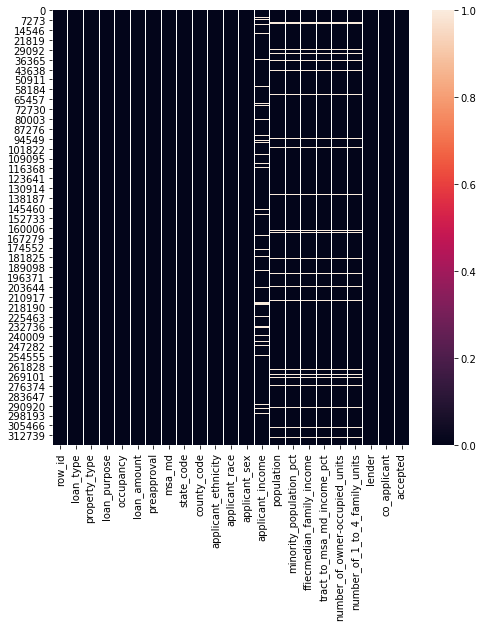

In [8]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

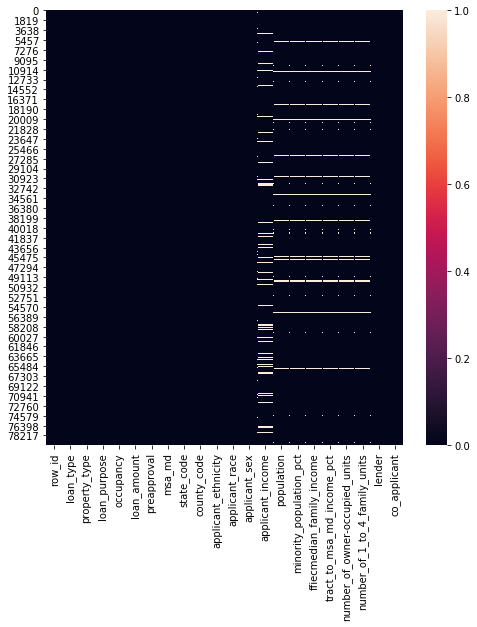

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(test.isnull())

## taking care of missing values in 
['applicant_income', 'population', 'minority_population_pct',
'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
'number_of_owner-occupied_units', 'number_of_1_to_4_family_units']

In [13]:
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  
0                          942.0    5053         False         0  
1                         1081.0    5952          True         1  
2                         1968.0    4576         False         1  
3                         1982.0    3108          True         0  
4                          893.0    5113         False         1

In [14]:
train.isnull().mean()

row_id                            0.000000
loan_type                         0.000000
property_type                     0.000000
loan_purpose                      0.000000
occupancy                         0.000000
loan_amount                       0.000000
preapproval                       0.000000
msa_md                            0.000000
state_code                        0.000000
county_code                       0.000000
applicant_ethnicity               0.000000
applicant_race                    0.000000
applicant_sex                     0.000000
applicant_income                  0.080094
population                        0.044959
minority_population_pct           0.044963
ffiecmedian_family_income         0.044903
tract_to_msa_md_income_pct        0.045072
number_of_owner-occupied_units    0.045184
number_of_1_to_4_family_units     0.045094
lender                            0.000000
co_applicant                      0.000000
accepted                          0.000000
dtype: floa

## 1.0 dealing with the missing data in applicant_income

In [15]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted'],
      dtype='object')

In [16]:
train_applicant_income = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income']]
train_applicant_income.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  
0               5              1              14.0  
1               5              1             143.0  
2               5              1              48.0  
3               5              1             454.0  
4               5              1              25.0

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_applicant_income, train.accepted, test_size=0.33, random_state=42)

In [20]:
def impute_na(df,variable,mean,median): 
    df[variable+'_mean'] = df[variable].fillna(mean)
    df[variable+'_median'] = df[variable].fillna(median)

In [21]:
mean = X_train.applicant_income.mean()
median = X_train.applicant_income.median()
mean,median

(102.13673601816929, 74.0)

In [22]:
impute_na(X_train,'applicant_income',mean,median)

In [23]:
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  \
133967               2              2             109.0   
186972               5              2              25.0   
183572               5              1              16.0   
42934                5              2              23.0   
194135               5              1              26.0   

        applicant_income_mean  applicant_income_median  
133967                  109.0                    109.0  
186972                   25.0                     25.0  
183572                   16.0                     16.0  
42934                    23.0                     23.0  
194135                   26.0                     26.0

In [24]:
impute_na(X_test,'applicant_income',mean,median)

In [25]:
#addition missingness features

# create variable indicating missingness in applicant_income
X_train['applicant_income_NA'] = np.where(X_train.applicant_income.isnull(),1,0)
X_test['applicant_income_NA'] = np.where(X_test.applicant_income.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  \
133967               2              2             109.0   
186972               5              2              25.0   
183572               5              1              16.0   
42934                5              2              23.0   
194135               5              1              26.0   

        applicant_income_mean  applicant_income_median  applicant_income_NA  
133967                  109.0                    109.0                    0  
186972                   25.0                     25.0                    0  
183572                   16.0                     16.0                    0  
42934                    23.0                     23.0                    0  
194135                   26.0                     26.0                    0

In [26]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols


## logistic reg 1.0

In [27]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['applicant_income','applicant_income_median','applicant_income_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['applicant_income','applicant_income_median','applicant_income_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['applicant_income','applicant_income_median','applicant_income_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit.fit(X_train.drop(['applicant_income','applicant_income_mean','applicant_income_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['applicant_income','applicant_income_mean','applicant_income_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['applicant_income','applicant_income_mean','applicant_income_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['applicant_income','applicant_income_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['applicant_income','applicant_income_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['applicant_income','applicant_income_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit.fit(X_train.drop(['applicant_income','applicant_income_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['applicant_income','applicant_income_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['applicant_income','applicant_income_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.658435602087257
Test set mean imputation
Logistic Reg roc_auc: 0.6557281212237609

Train set median imputation
Logistic Reg roc-auc: 0.6578737860685084
Test set median imputation
Logistic Reg roc_auc: 0.6551061062316377

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.6604642931008431
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.6583338828218761

Train set median imputation and missingness
Logistic Reg roc-auc: 0.6604642951892952
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6583339567167558



## concluding on applicant_income missing values
the missing data in the applicant_income has predictive powers to the target variable 

best approach to treat applicant_income missing values = mean imputation and missingness

In [22]:
# inplementation based on the conclussion above in applicant_income
train['applicant_income_NA'] = np.where(train.applicant_income.isnull(),1,0)
test['applicant_income_NA'] = np.where(test.applicant_income.isnull(),1,0)
train.applicant_income.fillna(train.applicant_income.mean(),inplace=True)
test.applicant_income.fillna(train.applicant_income.mean(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

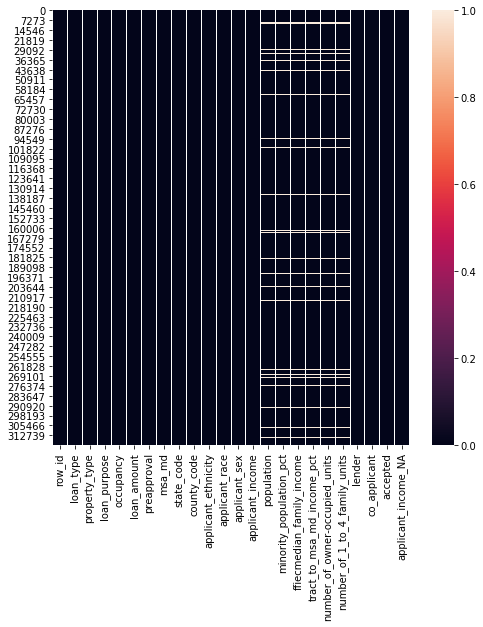

In [23]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.1 taking care of missing values in population

In [24]:
train.population.isnull().mean()

0.044959375

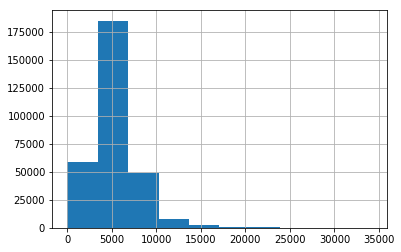

In [25]:
train.population.hist()

In [26]:
train.population.mean(),train.population.median()

(5419.888018507066, 4976.0)

In [27]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA'],
      dtype='object')

In [28]:
train_population = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income','applicant_income_NA', 'population']]
train_population.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
0               5              1              14.0                    0   
1               5              1             143.0                    0   
2               5              1              48.0                    0   
3               5              1             454.0                    0   
4               5              1              25.0                    0   

   population  
0      1993.0  
1      4402.0  
2      7829.0  
3      4691.0  
4      2408.0

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_population, train.accepted, test_size=0.33, random_state=42)

In [30]:
mean = X_train.population.mean()
median = X_train.population.median()
mean,median

(5418.1763023553185, 4978.0)

In [31]:
impute_na(X_train,'population',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_mean  population_median  
133967      4664.0           4664.0             4664.0  
186972      3238.0           3238.0             3238.0  
183572      3588.0           3588.0             3588.0  
42934       4712.0           4712.0             4712.0  
194135      6830.0           6830.0             6830.0

In [32]:
impute_na(X_test,'population',mean,median)

In [33]:
#addition missingness features

# create variable indicating missingness in population
X_train['population_NA'] = np.where(X_train.population.isnull(),1,0)
X_test['population_NA'] = np.where(X_test.population.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_mean  population_median  population_NA  
133967      4664.0           4664.0             4664.0              0  
186972      3238.0           3238.0             3238.0              0  
183572      3588.0           3588.0             3588.0              0  
42934       4712.0           4712.0             4712.0              0  
194135      6830.0           6830.0             6830.0              0

In [34]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## logistic reg 1.1

In [35]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['population','population_median','population_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['population','population_median','population_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['population','population_median','population_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit.fit(X_train.drop(['population','population_mean','population_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['population','population_mean','population_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['population','population_mean','population_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['population','population_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['population','population_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['population','population_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()


logit.fit(X_train.drop(['population','population_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['population','population_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['population','population_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.6607818458765429
Test set mean imputation
Logistic Reg roc_auc: 0.658548568970055

Train set median imputation
Logistic Reg roc-auc: 0.6609439430122419
Test set median imputation
Logistic Reg roc_auc: 0.6586928103402898

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.6818437196416925
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.6800682325948234

Train set median imputation and missingness
Logistic Reg roc-auc: 0.6818437232094652
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6800682272141283



## concluding on population missing values
the missing data in the population has predictive powers to the target variable 

best approach to treat population missing values = mean imputation and missingness

In [36]:
# inplementation based on the conclussion above in applicant_income
train['population_NA'] = np.where(train.population.isnull(),1,0)
test['population_NA'] = np.where(test.population.isnull(),1,0)
train.population.fillna(train.population.mean(),inplace=True)
test.population.fillna(train.population.mean(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

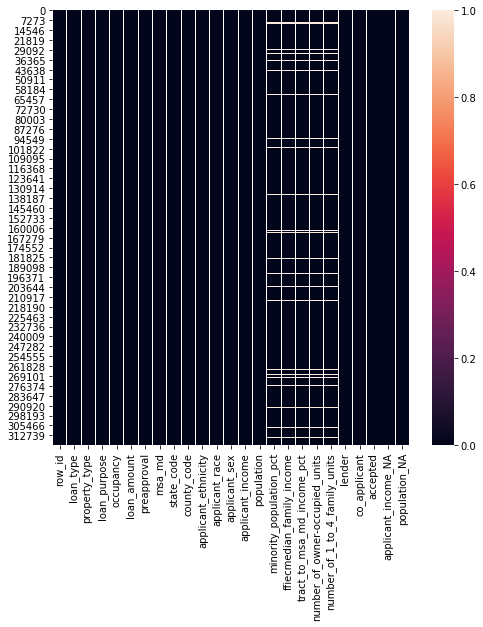

In [37]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.2 taking care of missing values in minority_population_pct

In [38]:
train.minority_population_pct.isnull().mean()

0.0449625

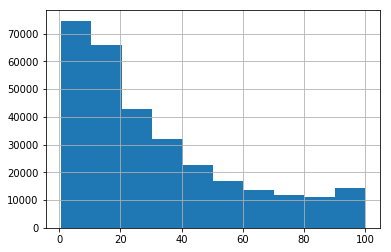

In [39]:
train.minority_population_pct.hist()

In [40]:
train.minority_population_pct.mean(),train.minority_population_pct.median()

(31.66157267712057, 22.917)

In [41]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA',
       'population_NA'],
      dtype='object')

In [42]:
train_minority_population_pct = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income','applicant_income_NA', 'population','population_NA','minority_population_pct']]
train_minority_population_pct.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
0               5              1              14.0                    0   
1               5              1             143.0                    0   
2               5              1              48.0                    0   
3               5              1             454.0                    0   
4               5              1              25.0                    0   

   population  population_NA  minority_population_pct  
0      1993.0              0                   29.525  
1      4402.0              0                   42.265  
2      7829.0              0                   44.841  
3      4691.0              0                    9.089  
4      2408.0              0                   30.840

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_minority_population_pct, train.accepted, test_size=0.33, random_state=42)

In [44]:
mean = X_train.minority_population_pct.mean()
median = X_train.minority_population_pct.median()
mean,median

(31.644552516630018, 22.898000000000003)

In [45]:
impute_na(X_train,'minority_population_pct',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_NA  minority_population_pct  \
133967      4664.0              0                   35.502   
186972      3238.0              0                    2.861   
183572      3588.0              0                    1.400   
42934       4712.0              0                   14.514   
194135      6830.0              0                   33.684   

        minority_population_pct_mean  minority_population_pct_median  
133967                        35.502                          35.502  
186972                         2.861                           2.861  
183572                         1.400                           1.400  
42934                         14.514                          14.514  
194135                        33.684                          33.684

In [46]:
impute_na(X_test,'minority_population_pct',mean,median)

In [47]:
#addition missingness features

# create variable indicating missingness in population
X_train['minority_population_pct_NA'] = np.where(X_train.minority_population_pct.isnull(),1,0)
X_test['minority_population_pct_NA'] = np.where(X_test.minority_population_pct.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_NA  minority_population_pct  \
133967      4664.0              0                   35.502   
186972      3238.0              0                    2.861   
183572      3588.0              0                    1.400   
42934       4712.0              0                   14.514   
194135      6830.0              0                   33.684   

        minority_population_pct_mean  minority_population_pct_median  \
133967                        35.502                          35.502   
186972                         2.861                           2.861   
183572                         1.400                           1.400   
42934                         14.514                          14.514   
194135                        33.684                          33.684   

        minority_population_pct_NA  
133967                           0  
186972                           0  
183572                           0  
42934                            0  
194135                           0

In [48]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## 1.2 logistic reg

In [49]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['minority_population_pct','minority_population_pct_median','minority_population_pct_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['minority_population_pct','minority_population_pct_median','minority_population_pct_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['minority_population_pct','minority_population_pct_median','minority_population_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['minority_population_pct','minority_population_pct_median','minority_population_pct_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['minority_population_pct','minority_population_pct_median','minority_population_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['minority_population_pct','minority_population_pct_mean','minority_population_pct_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['minority_population_pct','minority_population_pct_mean','minority_population_pct_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['minority_population_pct','minority_population_pct_mean','minority_population_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['minority_population_pct','minority_population_pct_mean','minority_population_pct_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['minority_population_pct','minority_population_pct_mean','minority_population_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['minority_population_pct','minority_population_pct_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['minority_population_pct','minority_population_pct_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['minority_population_pct','minority_population_pct_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['minority_population_pct','minority_population_pct_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['minority_population_pct','minority_population_pct_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['minority_population_pct','minority_population_pct_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['minority_population_pct','minority_population_pct_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['minority_population_pct','minority_population_pct_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['minority_population_pct','minority_population_pct_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['minority_population_pct','minority_population_pct_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.6871162571675211
Logistic Reg accuracy: 0.6334561567164179
Test set mean imputation
Logistic Reg roc_auc: 0.6856859146925225
Logistic Reg accuracy: 0.6320549242424243

Train set median imputation
Logistic Reg roc-auc: 0.6871166227336833
Logistic Reg accuracy: 0.6334561567164179
Test set median imputation
Logistic Reg roc_auc: 0.6856858809734998
Logistic Reg accuracy: 0.6320549242424243

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.687122811078753
Logistic Reg accuracy: 0.6334701492537314
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.6856863135813874
Logistic Reg accuracy: 0.6320549242424243

Train set median imputation and missingness
Logistic Reg roc-auc: 0.687122762609257
Logistic Reg accuracy: 0.6334701492537314
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6856862866779119
Logistic Reg accuracy: 0.6320549242424243



## concluding on minority_population_pct missing values
the missing data in the minority_population_pct has predictive powers to the target variable 

best approach to treat minority_population_pct missing values = median imputation

In [50]:
# inplementation based on the conclussion above in minority_population_pct
train.minority_population_pct.fillna(train.minority_population_pct.median(),inplace=True)
test.minority_population_pct.fillna(train.minority_population_pct.median(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

## note that addition pf missingness for minority_population_pct reduces the accuracy 
## because the missingness has been captured by the previous case 
## since missingness is across same rows 


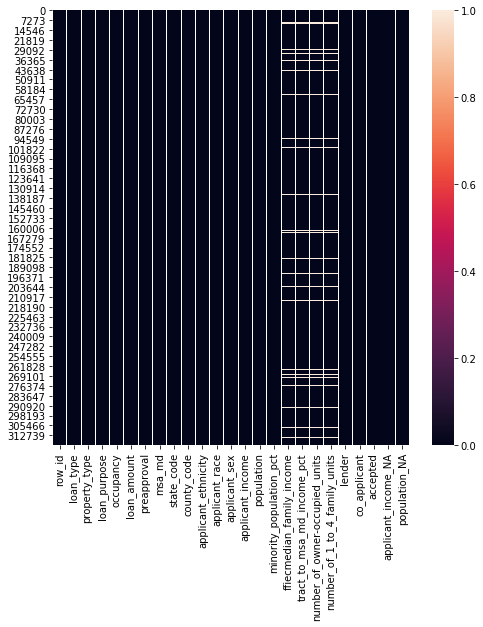

In [51]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.3 taking care of missing values in ffiecmedian_family_income

In [52]:
train.ffiecmedian_family_income.isnull().mean()

0.044903125

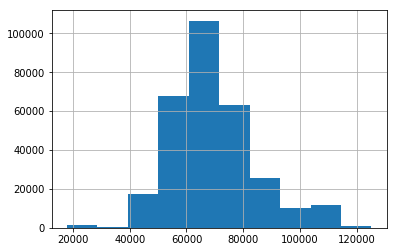

In [53]:
train.ffiecmedian_family_income.hist()

In [54]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA',
       'population_NA'],
      dtype='object')

In [55]:
train_ffiecmedian_family_income = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income','applicant_income_NA', 'population','population_NA','minority_population_pct','ffiecmedian_family_income']]
train_ffiecmedian_family_income.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
0               5              1              14.0                    0   
1               5              1             143.0                    0   
2               5              1              48.0                    0   
3               5              1             454.0                    0   
4               5              1              25.0                    0   

   population  population_NA  minority_population_pct  \
0      1993.0              0                   29.525   
1      4402.0              0                   42.265   
2      7829.0              0                   44.841   
3      4691.0              0                    9.089   
4      2408.0              0                   30.840   

   ffiecmedian_family_income  
0                    58433.0  
1                   109352.0  
2                    98621.0  
3                   112005.0  
4                    75925.0

In [56]:
X_train, X_test, y_train, y_test = train_test_split(train_ffiecmedian_family_income, train.accepted, test_size=0.33, random_state=42)

In [57]:
mean = X_train.ffiecmedian_family_income.mean()
median = X_train.ffiecmedian_family_income.median()
mean,median

(69235.62545690568, 67530.0)

In [58]:
impute_na(X_train,'ffiecmedian_family_income',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_NA  minority_population_pct  \
133967      4664.0              0                   35.502   
186972      3238.0              0                    2.861   
183572      3588.0              0                    1.400   
42934       4712.0              0                   14.514   
194135      6830.0              0                   33.684   

        ffiecmedian_family_income  ffiecmedian_family_income_mean  \
133967                    61596.0                         61596.0   
186972                    52637.0                         52637.0   
183572                    54685.0                         54685.0   
42934                     69057.0                         69057.0   
194135                    68914.0                         68914.0   

        ffiecmedian_family_income_median  
133967                           61596.0  
186972                           52637.0  
183572                           54685.0  
42934                            69057.0  
194135                           68914.0

In [59]:
impute_na(X_test,'ffiecmedian_family_income',mean,median)

In [60]:
#addition missingness features

# create variable indicating missingness in population
X_train['ffiecmedian_family_income_NA'] = np.where(X_train.ffiecmedian_family_income.isnull(),1,0)
X_test['ffiecmedian_family_income_NA'] = np.where(X_test.ffiecmedian_family_income.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  applicant_income_NA  \
133967               2              2             109.0                    0   
186972               5              2              25.0                    0   
183572               5              1              16.0                    0   
42934                5              2              23.0                    0   
194135               5              1              26.0                    0   

        population  population_NA  minority_population_pct  \
133967      4664.0              0                   35.502   
186972      3238.0              0                    2.861   
183572      3588.0              0                    1.400   
42934       4712.0              0                   14.514   
194135      6830.0              0                   33.684   

        ffiecmedian_family_income  ffiecmedian_family_income_mean  \
133967                    61596.0                         61596.0   
186972                    52637.0                         52637.0   
183572                    54685.0                         54685.0   
42934                     69057.0                         69057.0   
194135                    68914.0                         68914.0   

        ffiecmedian_family_income_median  ffiecmedian_family_income_NA  
133967                           61596.0                             0  
186972                           52637.0                             0  
183572                           54685.0                             0  
42934                            69057.0                             0  
194135                           68914.0                             0

In [61]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## 1.3 logistic reg

In [62]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median','ffiecmedian_family_income_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean','ffiecmedian_family_income_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean','ffiecmedian_family_income_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['ffiecmedian_family_income','ffiecmedian_family_income_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.6883140849519082
Logistic Reg accuracy: 0.634472947761194
Test set mean imputation
Logistic Reg roc_auc: 0.6866717638589398
Logistic Reg accuracy: 0.6328125

Train set median imputation
Logistic Reg roc-auc: 0.6883139170925585
Logistic Reg accuracy: 0.634472947761194
Test set median imputation
Logistic Reg roc_auc: 0.6866714166247481
Logistic Reg accuracy: 0.6328219696969697

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.6883779414678649
Logistic Reg accuracy: 0.6344962686567164
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.6866686954278691
Logistic Reg accuracy: 0.6328030303030303

Train set median imputation and missingness
Logistic Reg roc-auc: 0.6883780245708607
Logistic Reg accuracy: 0.6344962686567164
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6866687750621568
Logistic Reg accuracy: 0.6328030303030303



## concluding on ffiecmedian_family_income missing values
the missing data in the ffiecmedian_family_income has predictive powers to the target variable 

best approach to treat ffiecmedian_family_income missing values = median imputation

In [63]:
# inplementation based on the conclussion above in applicant_income
train.ffiecmedian_family_income.fillna(train.ffiecmedian_family_income.mean(),inplace=True)
test.ffiecmedian_family_income.fillna(train.ffiecmedian_family_income.mean(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

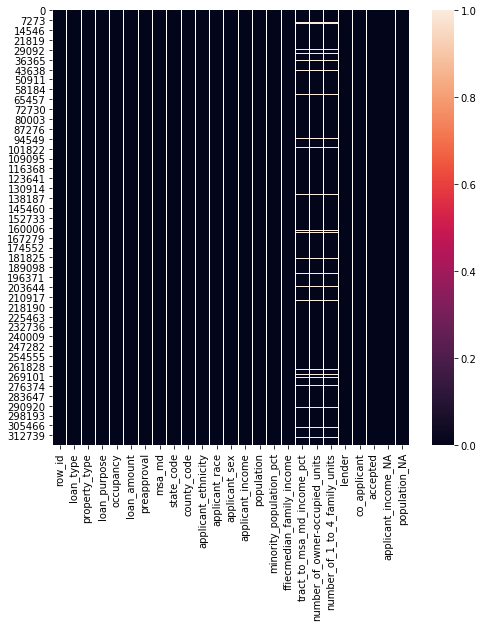

In [64]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.4 taking care of missing values in tract_to_msa_md_income_pct

In [65]:
train.tract_to_msa_md_income_pct.isnull().mean()

0.045071875

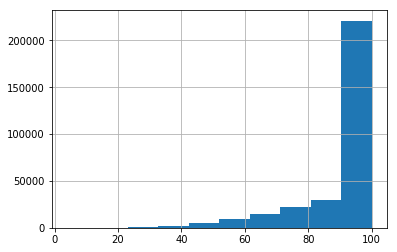

In [66]:
train.tract_to_msa_md_income_pct.hist()

In [67]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA',
       'population_NA'],
      dtype='object')

In [68]:
train_tract_to_msa_md_income_pct = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income','applicant_income_NA',
       'population_NA','tract_to_msa_md_income_pct']]
train_tract_to_msa_md_income_pct.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  applicant_income_NA  \
0                   29.525                    58433.0                    0   
1                   42.265                   109352.0                    0   
2                   44.841                    98621.0                    0   
3                    9.089                   112005.0                    0   
4                   30.840                    75925.0                    0   

   population_NA  tract_to_msa_md_income_pct  
0              0                      68.959  
1              0                     100.000  
2              0                     100.000  
3              0                     100.000  
4              0                      92.052

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_tract_to_msa_md_income_pct, train.accepted, test_size=0.33, random_state=42)

In [70]:
mean = X_train.tract_to_msa_md_income_pct.mean()
median = X_train.tract_to_msa_md_income_pct.median()
mean,median

(91.82866221994482, 100.0)

In [71]:
impute_na(X_train,'tract_to_msa_md_income_pct',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        applicant_income_NA  population_NA  tract_to_msa_md_income_pct  \
133967                    0              0                     100.000   
186972                    0              0                     100.000   
183572                    0              0                      90.838   
42934                     0              0                     100.000   
194135                    0              0                     100.000   

        tract_to_msa_md_income_pct_mean  tract_to_msa_md_income_pct_median  
133967                          100.000                            100.000  
186972                          100.000                            100.000  
183572                           90.838                             90.838  
42934                           100.000                            100.000  
194135                          100.000                            100.000

In [72]:
impute_na(X_test,'tract_to_msa_md_income_pct',mean,median)

In [73]:
#addition missingness features

# create variable indicating missingness in population
X_train['tract_to_msa_md_income_pct_NA'] = np.where(X_train.tract_to_msa_md_income_pct.isnull(),1,0)
X_test['tract_to_msa_md_income_pct_NA'] = np.where(X_test.tract_to_msa_md_income_pct.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        applicant_income_NA  population_NA  tract_to_msa_md_income_pct  \
133967                    0              0                     100.000   
186972                    0              0                     100.000   
183572                    0              0                      90.838   
42934                     0              0                     100.000   
194135                    0              0                     100.000   

        tract_to_msa_md_income_pct_mean  tract_to_msa_md_income_pct_median  \
133967                          100.000                            100.000   
186972                          100.000                            100.000   
183572                           90.838                             90.838   
42934                           100.000                            100.000   
194135                          100.000                            100.000   

        tract_to_msa_md_income_pct_NA  
133967                              0  
186972                              0  
183572                              0  
42934                               0  
194135                              0

In [74]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## 1.4 logistic reg

In [75]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median','tract_to_msa_md_income_pct_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean','tract_to_msa_md_income_pct_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean','tract_to_msa_md_income_pct_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['tract_to_msa_md_income_pct','tract_to_msa_md_income_pct_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.6895137701100044
Logistic Reg accuracy: 0.6351305970149254
Test set mean imputation
Logistic Reg roc_auc: 0.6881546185071017
Logistic Reg accuracy: 0.6344318181818182

Train set median imputation
Logistic Reg roc-auc: 0.6895122352716392
Logistic Reg accuracy: 0.6351445895522388
Test set median imputation
Logistic Reg roc_auc: 0.6881550410710252
Logistic Reg accuracy: 0.6344128787878788

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.6895317100888585
Logistic Reg accuracy: 0.635107276119403
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.6881529239468518
Logistic Reg accuracy: 0.6343939393939394

Train set median imputation and missingness
Logistic Reg roc-auc: 0.6895317533372238
Logistic Reg accuracy: 0.6351119402985075
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6881529210771478
Logistic Reg accuracy: 0.6343939393939394



## concluding on tract_to_msa_md_income_pct missing values
the missing data in the tract_to_msa_md_income_pct has predictive powers to the target variable 

best approach to treat tract_to_msa_md_income_pct missing values = mean imputation

In [76]:
# inplementation based on the conclussion above in applicant_income
train.tract_to_msa_md_income_pct.fillna(train.tract_to_msa_md_income_pct.mean(),inplace=True)
test.tract_to_msa_md_income_pct.fillna(train.tract_to_msa_md_income_pct.mean(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

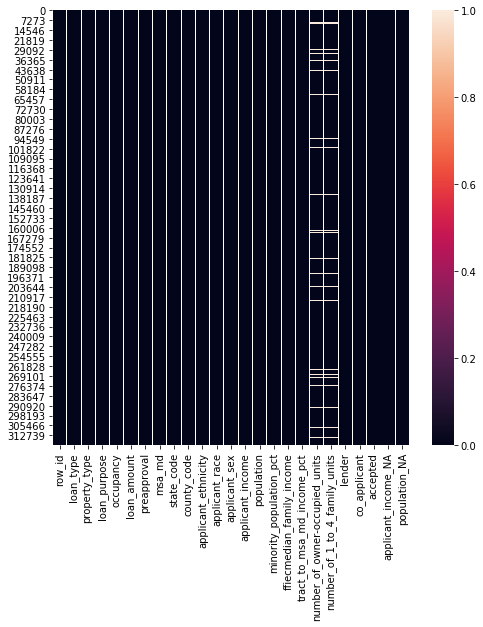

In [77]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.5 taking care of missing values in number_of_owner-occupied_units

In [78]:
train['number_of_owner-occupied_units'].isnull().mean()

0.045184375

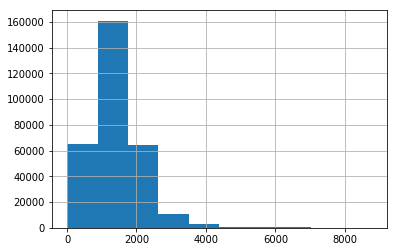

In [79]:
train['number_of_owner-occupied_units'].hist()

In [80]:
# list(train.columns)

In [81]:
# train.columns=['row_id','loan_type','property_type','loan_purpose','occupancy','loan_amount','preapproval','msa_md','state_code','county_code','applicant_ethnicity','applicant_race',
#  'applicant_sex','applicant_income','population','minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct','number_of_owner_occupied_units','number_of_1_to_4_family_units',
#  'lender','co_applicant','accepted','applicant_income_NA','population_NA']

In [82]:
# test.columns=['row_id','loan_type',
#  'property_type','loan_purpose',
#  'occupancy','loan_amount','preapproval','msa_md','state_code','county_code','applicant_ethnicity','applicant_race','applicant_sex','applicant_income','population','minority_population_pct',
#  'ffiecmedian_family_income','tract_to_msa_md_income_pct','number_of_owner_occupied_units','number_of_1_to_4_family_units','lender','co_applicant','applicant_income_NA',
#  'population_NA']

In [83]:
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

In [84]:
train_number_of_owner_occupied_units = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units','applicant_income_NA',
       'population_NA']]
train_number_of_owner_occupied_units.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   applicant_income_NA  population_NA  
0                    0              0  
1                    0              0  
2                    0              0  
3                    0              0  
4                    0              0

In [85]:
X_train, X_test, y_train, y_test = train_test_split(train_number_of_owner_occupied_units, train.accepted, test_size=0.33, random_state=42)

In [86]:
mean = X_train['number_of_owner-occupied_units'].mean()
median = X_train['number_of_owner-occupied_units'].median()
mean,median

(1427.9742489479902, 1328.0)

In [87]:
impute_na(X_train,'number_of_owner-occupied_units',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
133967                     100.000                          1712.0   
186972                     100.000                          1160.0   
183572                      90.838                          1152.0   
42934                      100.000                          1508.0   
194135                     100.000                          1454.0   

        applicant_income_NA  population_NA  \
133967                    0              0   
186972                    0              0   
183572                    0              0   
42934                     0              0   
194135                    0              0   

        number_of_owner-occupied_units_mean  \
133967                               1712.0   
186972                               1160.0   
183572                               1152.0   
42934                                1508.0   
194135                               1454.0   

        number_of_owner-occupied_units_median  
133967                                 1712.0  
186972                                 1160.0  
183572                                 1152.0  
42934                                  1508.0  
194135                                 1454.0

In [88]:
impute_na(X_test,'number_of_owner-occupied_units',mean,median)

In [89]:
#addition missingness features

# create variable indicating missingness in population
X_train['number_of_owner-occupied_units_NA'] = np.where(X_train['number_of_owner-occupied_units'].isnull(),1,0)
X_test['number_of_owner-occupied_units_NA'] = np.where(X_test['number_of_owner-occupied_units'].isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
133967                     100.000                          1712.0   
186972                     100.000                          1160.0   
183572                      90.838                          1152.0   
42934                      100.000                          1508.0   
194135                     100.000                          1454.0   

        applicant_income_NA  population_NA  \
133967                    0              0   
186972                    0              0   
183572                    0              0   
42934                     0              0   
194135                    0              0   

        number_of_owner-occupied_units_mean  \
133967                               1712.0   
186972                               1160.0   
183572                               1152.0   
42934                                1508.0   
194135                               1454.0   

        number_of_owner-occupied_units_median  \
133967                                 1712.0   
186972                                 1160.0   
183572                                 1152.0   
42934                                  1508.0   
194135                                 1454.0   

        number_of_owner-occupied_units_NA  
133967                                  0  
186972                                  0  
183572                                  0  
42934                                   0  
194135                                  0

In [90]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## 1.5 logistic reg

In [91]:
# # comparing the performance of logistic Regression using the applicant_income as case study 

# logit = LogisticRegression(random_state=42,C=1000)
# logit.fit(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median','number_of_owner_occupied_units_NA'],axis=1),y_train)
# print('Train set mean imputation')
# pred = logit.predict_proba(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set mean imputation')
# pred = logit.predict_proba(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()


# logit.fit(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean','number_of_owner_occupied_units_NA'],axis=1),y_train)
# print('Train set median imputation')
# pred = logit.predict_proba(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set median imputation')
# pred = logit.predict_proba(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean','number_of_owner_occupied_units_NA'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()



# logit = LogisticRegression(random_state=42,C=1000)
# logit.fit(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median'],axis=1),y_train)
# print('Train set mean imputation and missingness')
# pred = logit.predict_proba(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set mean imputation and missingness')
# pred = logit.predict_proba(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_median'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()


# logit.fit(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean'],axis=1),y_train)
# print('Train set median imputation and missingness')
# pred = logit.predict_proba(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set median imputation and missingness')
# pred = logit.predict_proba(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['number_of_owner_occupied_units','number_of_owner_occupied_units_mean'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()



## concluding on number_of_owner_occupied_units missing values
the missing data in the number_of_owner_occupied_units has predictive powers to the target variable 

best approach to treat number_of_owner_occupied_units missing values = median imputation and missingness

In [92]:
# inplementation based on the conclussion above in applicant_income
train['number_of_owner-occupied_units_NA'] = np.where(train['number_of_owner-occupied_units'].isnull(),1,0)
test['number_of_owner-occupied_units_NA'] = np.where(test['number_of_owner-occupied_units'].isnull(),1,0)
train['number_of_owner-occupied_units'].fillna(train['number_of_owner-occupied_units'].median(),inplace=True)
test['number_of_owner-occupied_units'].fillna(train['number_of_owner-occupied_units'].median(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  
0                    0              0                                  0  
1                    0              0                                  0  
2                    0              0                                  0  
3                    0              0                                  0  
4                    0              0                                  0

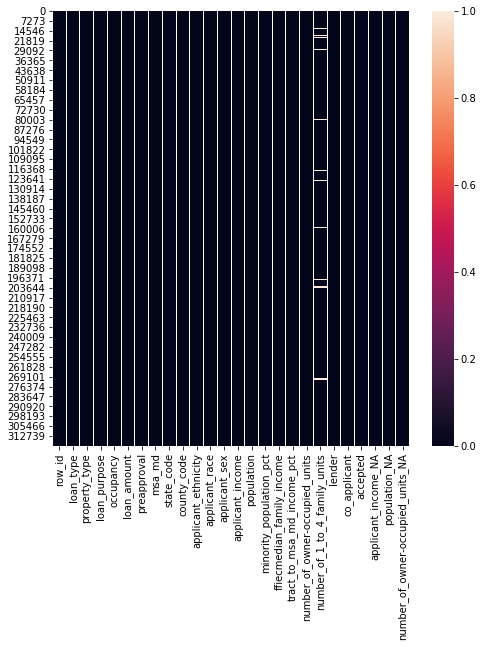

In [93]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

## 1.5 taking care of missing values in number_of_1_to_4_family_units

In [94]:
train.number_of_1_to_4_family_units.isnull().mean()

0.04509375

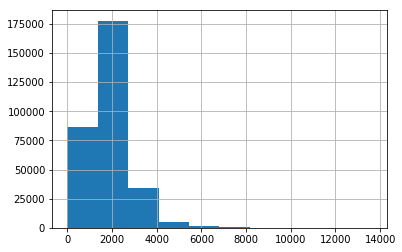

In [95]:
train.number_of_1_to_4_family_units.hist()

In [96]:
train.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA',
       'population_NA', 'number_of_owner-occupied_units_NA'],
      dtype='object')

In [97]:
train_number_of_1_to_4_family_units = train[['loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'applicant_income_NA',
       'population_NA', 'number_of_owner-occupied_units_NA']]
train_number_of_1_to_4_family_units.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0          1              1             2          1         78.0   
1          1              1             1          1        322.0   
2          1              1             1          1        144.0   
3          1              1             3          1        523.0   
4          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  applicant_income_NA  population_NA  \
0                          942.0                    0              0   
1                         1081.0                    0              0   
2                         1968.0                    0              0   
3                         1982.0                    0              0   
4                          893.0                    0              0   

   number_of_owner-occupied_units_NA  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0

In [98]:
X_train, X_test, y_train, y_test = train_test_split(train_number_of_1_to_4_family_units, train.accepted, test_size=0.33, random_state=42)

In [99]:
mean = X_train.number_of_1_to_4_family_units.mean()
median = X_train.number_of_1_to_4_family_units.median()
mean,median

(1885.9446215275575, 1754.0)

In [100]:
impute_na(X_train,'number_of_1_to_4_family_units',mean,median)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
133967                     100.000                          1712.0   
186972                     100.000                          1160.0   
183572                      90.838                          1152.0   
42934                      100.000                          1508.0   
194135                     100.000                          1454.0   

        number_of_1_to_4_family_units  applicant_income_NA  population_NA  \
133967                         1504.0                    0              0   
186972                         1501.0                    0              0   
183572                         1428.0                    0              0   
42934                          1907.0                    0              0   
194135                         2107.0                    0              0   

        number_of_owner-occupied_units_NA  number_of_1_to_4_family_units_mean  \
133967                                  0                              1504.0   
186972                                  0                              1501.0   
183572                                  0                              1428.0   
42934                                   0                              1907.0   
194135                                  0                              2107.0   

        number_of_1_to_4_family_units_median  
133967                                1504.0  
186972                                1501.0  
183572                                1428.0  
42934                                 1907.0  
194135                                2107.0

In [101]:
impute_na(X_test,'number_of_1_to_4_family_units',mean,median)

In [102]:
#addition missingness features

# create variable indicating missingness in population
X_train['number_of_1_to_4_family_units_NA'] = np.where(X_train.number_of_1_to_4_family_units.isnull(),1,0)
X_test['number_of_1_to_4_family_units_NA'] = np.where(X_test.number_of_1_to_4_family_units.isnull(),1,0)
X_train.head()

loan_type  property_type  loan_purpose  occupancy  loan_amount  \
133967          1              1             1          1        587.0   
186972          2              1             1          1        107.0   
183572          1              1             3          1        125.0   
42934           1              1             3          1         53.0   
194135          2              1             3          1         12.0   

        preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
133967            2      24          37           20                    2   
186972            3      36           9            7                    2   
183572            3      -1          22          299                    2   
42934             3      22          10          297                    2   
194135            3     333           6          299                    2   

        applicant_race  applicant_sex  applicant_income  population  \
133967               2              2             109.0      4664.0   
186972               5              2              25.0      3238.0   
183572               5              1              16.0      3588.0   
42934                5              2              23.0      4712.0   
194135               5              1              26.0      6830.0   

        minority_population_pct  ffiecmedian_family_income  \
133967                   35.502                    61596.0   
186972                    2.861                    52637.0   
183572                    1.400                    54685.0   
42934                    14.514                    69057.0   
194135                   33.684                    68914.0   

        tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
133967                     100.000                          1712.0   
186972                     100.000                          1160.0   
183572                      90.838                          1152.0   
42934                      100.000                          1508.0   
194135                     100.000                          1454.0   

        number_of_1_to_4_family_units  applicant_income_NA  population_NA  \
133967                         1504.0                    0              0   
186972                         1501.0                    0              0   
183572                         1428.0                    0              0   
42934                          1907.0                    0              0   
194135                         2107.0                    0              0   

        number_of_owner-occupied_units_NA  number_of_1_to_4_family_units_mean  \
133967                                  0                              1504.0   
186972                                  0                              1501.0   
183572                                  0                              1428.0   
42934                                   0                              1907.0   
194135                                  0                              2107.0   

        number_of_1_to_4_family_units_median  number_of_1_to_4_family_units_NA  
133967                                1504.0                                 0  
186972                                1501.0                                 0  
183572                                1428.0                                 0  
42934                                 1907.0                                 0  
194135                                2107.0                                 0

In [103]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

## 1.6 logistic reg

In [104]:
# comparing the performance of logistic Regression using the applicant_income as case study 

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median','number_of_1_to_4_family_units_NA'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean','number_of_1_to_4_family_units_NA'],axis=1),y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation')
pred = logit.predict_proba(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean','number_of_1_to_4_family_units_NA'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median'],axis=1),y_train)
print('Train set mean imputation and missingness')
pred = logit.predict_proba(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation and missingness')
pred = logit.predict_proba(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_median'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


logit.fit(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean'],axis=1),y_train)
print('Train set median imputation and missingness')
pred = logit.predict_proba(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set median imputation and missingness')
pred = logit.predict_proba(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['number_of_1_to_4_family_units','number_of_1_to_4_family_units_mean'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()



Train set mean imputation
Logistic Reg roc-auc: 0.6903518561642867
Logistic Reg accuracy: 0.635722947761194
Test set mean imputation
Logistic Reg roc_auc: 0.6888856045923013
Logistic Reg accuracy: 0.6346496212121212

Train set median imputation
Logistic Reg roc-auc: 0.6903514376036485
Logistic Reg accuracy: 0.6357182835820896
Test set median imputation
Logistic Reg roc_auc: 0.6888852465967192
Logistic Reg accuracy: 0.6346496212121212

Train set mean imputation and missingness
Logistic Reg roc-auc: 0.6903574752320807
Logistic Reg accuracy: 0.6357042910447761
Test set mean imputation and missingness
Logistic Reg roc_auc: 0.688892825843866
Logistic Reg accuracy: 0.6346685606060606

Train set median imputation and missingness
Logistic Reg roc-auc: 0.6903575188285214
Logistic Reg accuracy: 0.6357042910447761
Test set median imputation and missingness
Logistic Reg roc_auc: 0.6888928391162474
Logistic Reg accuracy: 0.6346685606060606



## concluding on number_of_1_to_4_family_units missing values
the missing data in the number_of_1_to_4_family_units has predictive powers to the target variable 

best approach to treat number_of_1_to_4_family_units missing values = mean imputation and missingness

In [105]:
# inplementation based on the conclussion above in applicant_income
train['number_of_1_to_4_family_units_NA'] = np.where(train.number_of_1_to_4_family_units.isnull(),1,0)
test['number_of_1_to_4_family_units_NA'] = np.where(test.number_of_1_to_4_family_units.isnull(),1,0)
train.number_of_1_to_4_family_units.fillna(train.number_of_1_to_4_family_units.mean(),inplace=True)
test.number_of_1_to_4_family_units.fillna(train.number_of_1_to_4_family_units.mean(),inplace=True)
train.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0

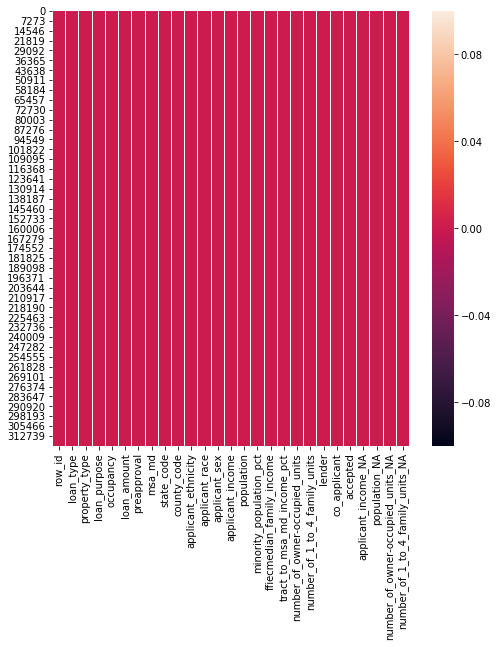

In [106]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.isnull())

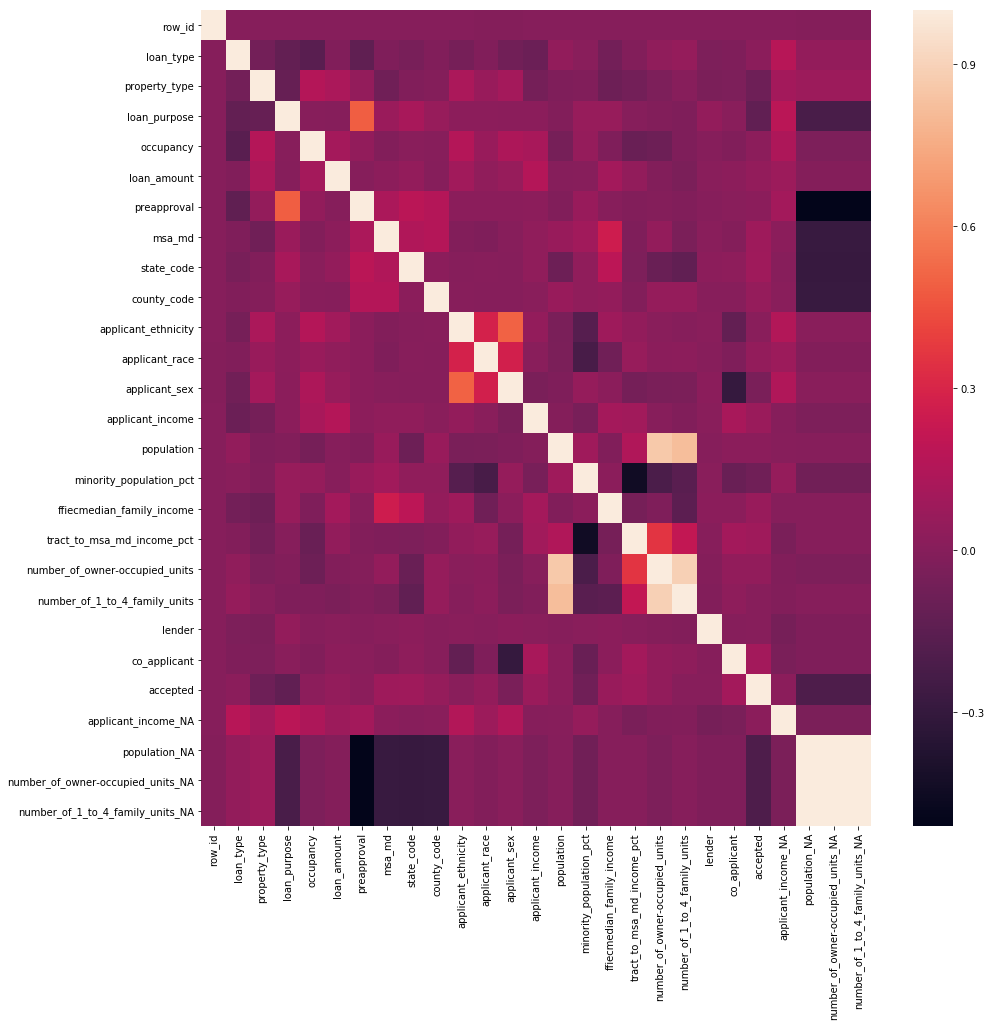

In [107]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr())

In [108]:
train_copy = train.copy()
test_copy = test.copy()

## 2.0 OUTLIERS

In [109]:
train_copy.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0

In [110]:
test_copy.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  304897          2              1             3          1        113.0   
1  386541          1              1             2          1         10.0   
2  453817          1              1             3          1        270.0   
3  352553          3              1             1          1        514.0   
4  273259          1              1             1          1         92.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3     356           5           98                    3   
1            3      10          34           11                    2   
2            3      24          37           20                    1   
3            3      10          34           11                    2   
4            3     150          14            3                    2   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              47.0      3256.0   
1               5              1              12.0      7274.0   
2               5              2              75.0      4835.0   
3               5              1             159.0      7542.0   
4               5              1              43.0      5407.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   24.824                    52771.0   
1                   16.243                    87259.0   
2                   86.704                    64204.0   
3                   15.455                    87564.0   
4                   18.518                    63502.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                     100.000                           800.0   
1                     100.000                          2097.0   
2                     100.000                           864.0   
3                      97.056                          2529.0   
4                     100.000                          1747.0   

   number_of_1_to_4_family_units  lender  co_applicant  applicant_income_NA  \
0                         1013.0    5684         False                    0   
1                         2674.0    4701          True                    0   
2                         1049.0    5123          True                    0   
3                         2985.0     814         False                    0   
4                         1888.0    1143         False                    0   

   population_NA  number_of_owner-occupied_units_NA  \
0              0                                  0   
1              0                                  0   
2              0                                  0   
3              0                                  0   
4              0                                  0   

   number_of_1_to_4_family_units_NA  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0

## 2.0 loan amount 

Text(0.5, 0, 'loan_amount')

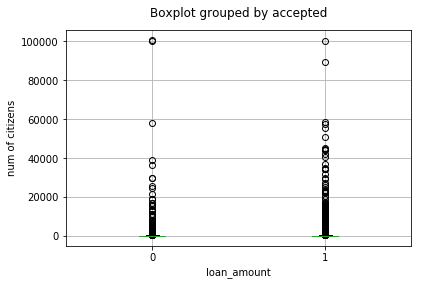

In [111]:
fig = train_copy.boxplot(column='loan_amount',by='accepted')
fig.set_title('')
fig.set_ylabel('num of citizens')
fig.set_xlabel('loan_amount')

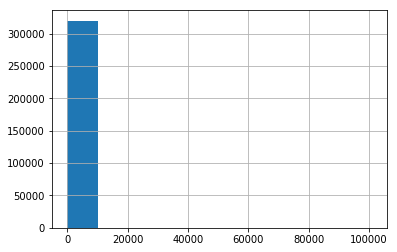

In [112]:
train_copy.loan_amount.hist()

In [113]:
# upper and lower boundaries for the outliers according to interquantile proximity rule

IQR = train_copy.loan_amount.quantile(0.75) - train_copy.loan_amount.quantile(0.25)

lower_fence = train_copy.loan_amount.quantile(0.25) - (IQR * 1.0)
Upper_fence = train_copy.loan_amount.quantile(0.75) + (IQR * 1.5)
lower_fence,Upper_fence

(-80.0, 525.5)

In [114]:
train_copy.loc[train_copy.loan_amount>Upper_fence,'loan_amount']= Upper_fence #replacing this outliers with Upper_fence(which is the boundary obtained by IQR assumption)
test_copy.loc[test_copy.loan_amount>Upper_fence,'loan_amount']= Upper_fence #replacing this outliers with Upper_fence(which is the boundary obtained by IQR assumption)
train_copy.loc[train_copy.loan_amount<lower_fence,'loan_amount']= lower_fence #replacing this outliers with lower_fence(which is the boundary obtained by IQR assumption)
test_copy.loc[test_copy.loan_amount<lower_fence,'loan_amount']= lower_fence #replacing this outliers with lower_fence(which is the boundary obtained by IQR assumption)


Text(0.5, 0, 'loan_amount')

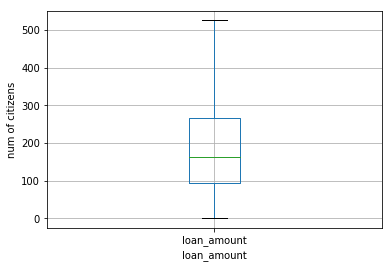

In [115]:
fig = train_copy.boxplot(column='loan_amount')
fig.set_title('')
fig.set_ylabel('num of citizens')
fig.set_xlabel('loan_amount')

In [116]:
train_copy.head()

row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
0  110049          1              1             2          1         78.0   
1   83668          1              1             1          1        322.0   
2  253898          1              1             1          1        144.0   
3   97905          1              1             3          1        523.0   
4  417495          1              1             3          1        143.0   

   preapproval  msa_md  state_code  county_code  applicant_ethnicity  \
0            3      77          31           20                    2   
1            2     358          32            2                    2   
2            3     139           3          299                    1   
3            3     266          48           83                    2   
4            3     171          52          257                    1   

   applicant_race  applicant_sex  applicant_income  population  \
0               5              1              14.0      1993.0   
1               5              1             143.0      4402.0   
2               5              1              48.0      7829.0   
3               5              1             454.0      4691.0   
4               5              1              25.0      2408.0   

   minority_population_pct  ffiecmedian_family_income  \
0                   29.525                    58433.0   
1                   42.265                   109352.0   
2                   44.841                    98621.0   
3                    9.089                   112005.0   
4                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0

## 2.1 msa_sd

Text(0.5, 0, 'msa_md')

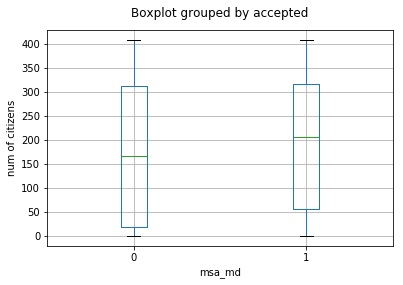

In [117]:
fig = train_copy.boxplot(column='msa_md',by='accepted')
fig.set_title('')
fig.set_ylabel('num of citizens')
fig.set_xlabel('msa_md')

## 2.2 applicant_income

Text(0.5, 0, 'applicant_income')

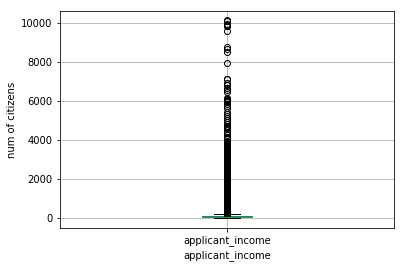

In [118]:
fig = train_copy.boxplot(column='applicant_income')
fig.set_title('')
fig.set_ylabel('num of citizens')
fig.set_xlabel('applicant_income')

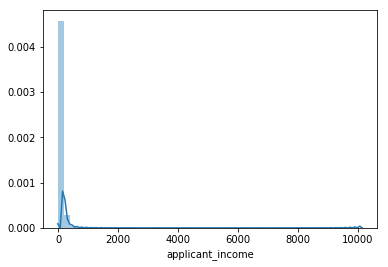

In [119]:
sns.distplot(train_copy.applicant_income)

In [120]:
train_copy.applicant_income.describe()

count    320000.000000
mean        102.270129
std         145.414041
min           1.000000
25%          49.000000
50%          79.000000
75%         112.000000
max       10139.000000
Name: applicant_income, dtype: float64

In [121]:
upper_b = train_copy.applicant_income.mean() + 3*train_copy.applicant_income.std()
upper_b

538.5122512912164

In [122]:
train_copy.loc[train_copy.applicant_income>upper_b,'applicant_income']= upper_b #replacing this outliers with Upper_fence(which is the boundary obtained by Gaussian assumption)
test_copy.loc[test_copy.applicant_income>upper_b,'applicant_income']= upper_b #replacing this outliers with Upper_fence(which is the boundary obtained by Gaussian assumption)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(train_copy, train_copy.accepted, test_size=0.33, random_state=42)

In [124]:
#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

In [125]:
# base model

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['row_id','accepted'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


Train set mean imputation
Logistic Reg roc-auc: 0.6996217387629459
Logistic Reg accuracy: 0.6464132462686567
Test set mean imputation
Logistic Reg roc_auc: 0.6985011359902895
Logistic Reg accuracy: 0.6465719696969697



## 3.0 Categorical features

In [126]:
categorical_col = ['loan_type','property_type','loan_purpose','occupancy','preapproval','applicant_ethnicity','applicant_race','applicant_sex']

In [127]:
df_cat_train = pd.DataFrame(data=train_copy,columns=categorical_col)
df_cat_test = pd.DataFrame(data=test_copy,columns=categorical_col)
df_cat_train.head()

loan_type  property_type  loan_purpose  occupancy  preapproval  \
0          1              1             2          1            3   
1          1              1             1          1            2   
2          1              1             1          1            3   
3          1              1             3          1            3   
4          1              1             3          1            3   

   applicant_ethnicity  applicant_race  applicant_sex  
0                    2               5              1  
1                    2               5              1  
2                    1               5              1  
3                    2               5              1  
4                    1               5              1

In [128]:
def freq_dist(df_categories):
    category_count = df_categories['property_type'].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_count.index,category_count.values, alpha = 0.9)
    plt.title('frequency distributio of property_type')
    plt.ylabel('number of occurrences',fontsize = 12)
    plt.xlabel('property_type',fontsize = 12)
    plt.show()

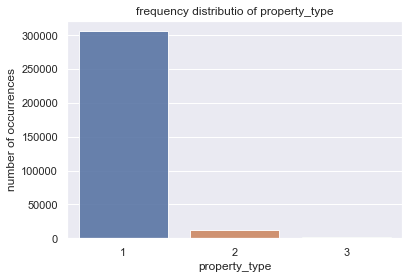

In [129]:
freq_dist(df_cat_train)

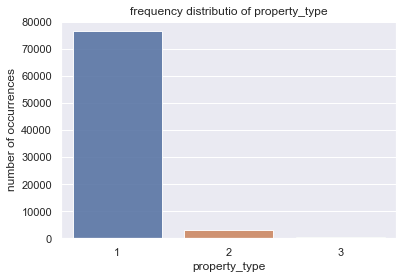

In [130]:
freq_dist(df_cat_test)

In [131]:
def freq_dist(df_categories):
    category_count = df_categories['loan_purpose'].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_count.index,category_count.values, alpha = 0.9)
    plt.title('frequency distributio of loan_purpose')
    plt.ylabel('number of occurrences',fontsize = 12)
    plt.xlabel('loan_purpose',fontsize = 12)
    plt.show()

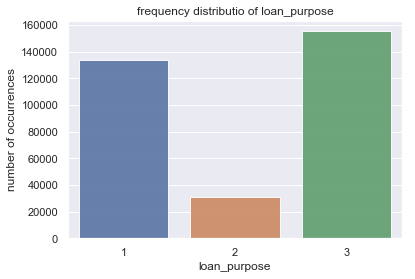

In [132]:
freq_dist(df_cat_train)

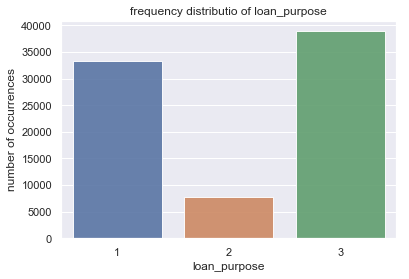

In [133]:
freq_dist(df_cat_test)

# big change

In [134]:
df_cat_train = pd.concat([df_cat_train,pd.get_dummies(df_cat_train['loan_purpose'],prefix='loan_purpose_',drop_first= False)],axis = 1)
df_cat_train.drop(columns=['loan_purpose'],inplace= True,axis=1)
df_cat_test = pd.concat([df_cat_test,pd.get_dummies(df_cat_test['loan_purpose'],prefix='loan_purpose_',drop_first= False)],axis = 1)
df_cat_test.drop(columns=['loan_purpose'],inplace= True,axis=1)
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_ethnicity  \
0          1              1          1            3                    2   
1          1              1          1            2                    2   
2          1              1          1            3                    1   
3          1              1          1            3                    2   
4          1              1          1            3                    1   

   applicant_race  applicant_sex  loan_purpose__1  loan_purpose__2  \
0               5              1                0                1   
1               5              1                1                0   
2               5              1                1                0   
3               5              1                0                0   
4               5              1                0                0   

   loan_purpose__3  
0                0  
1                0  
2                0  
3                1  
4                1

In [135]:
cols = ['loan_purpose__1','loan_purpose__2','loan_purpose__3']
col = 'loan_purpose'

In [136]:
def categorical_func(train_df,test_df,df_new_cat_train,df_new_cat_test,col,cols):
    train_copy = pd.concat([train_df,df_new_cat_train[cols]],axis=1)
    train_copy.drop(columns=[col],inplace=True)
    test_copy = pd.concat([test_df,df_new_cat_test[cols]],axis=1)
    test_copy.drop(columns=[col],inplace=True)
    return train_copy,test_copy

In [137]:
new_train , new_test = categorical_func(train_copy,test_copy,df_cat_train,df_cat_test,col,cols)
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_ethnicity  applicant_race  \
0      77          31           20                    2               5   
1     358          32            2                    2               5   
2     139           3          299                    1               5   
3     266          48           83                    2               5   
4     171          52          257                    1               5   

   applicant_sex  applicant_income  population  minority_population_pct  \
0              1              14.0      1993.0                   29.525   
1              1             143.0      4402.0                   42.265   
2              1              48.0      7829.0                   44.841   
3              1             454.0      4691.0                    9.089   
4              1              25.0      2408.0                   30.840   

   ffiecmedian_family_income  tract_to_msa_md_income_pct  \
0                    58433.0                      68.959   
1                   109352.0                     100.000   
2                    98621.0                     100.000   
3                   112005.0                     100.000   
4                    75925.0                      92.052   

   number_of_owner-occupied_units  number_of_1_to_4_family_units  lender  \
0                           918.0                          942.0    5053   
1                           773.0                         1081.0    5952   
2                          1799.0                         1968.0    4576   
3                          1561.0                         1982.0    3108   
4                           670.0                          893.0    5113   

   co_applicant  accepted  applicant_income_NA  population_NA  \
0         False         0                    0              0   
1          True         1                    0              0   
2         False         1                    0              0   
3          True         0                    0              0   
4         False         1                    0              0   

   number_of_owner-occupied_units_NA  number_of_1_to_4_family_units_NA  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

   loan_purpose__1  loan_purpose__2  loan_purpose__3  
0                0                1                0  
1                1                0                0  
2                1                0                0  
3                0                0                1  
4                0                0                1

In [138]:
new_test.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  304897          2              1          1        113.0            3   
1  386541          1              1          1         10.0            3   
2  453817          1              1          1        270.0            3   
3  352553          3              1          1        514.0            3   
4  273259          1              1          1         92.0            3   

   msa_md  state_code  county_code  applicant_ethnicity  applicant_race  \
0     356           5           98                    3               5   
1      10          34           11                    2               5   
2      24          37           20                    1               5   
3      10          34           11                    2               5   
4     150          14            3                    2               5   

   applicant_sex  applicant_income  population  minority_population_pct  \
0              1              47.0      3256.0                   24.824   
1              1              12.0      7274.0                   16.243   
2              2              75.0      4835.0                   86.704   
3              1             159.0      7542.0                   15.455   
4              1              43.0      5407.0                   18.518   

   ffiecmedian_family_income  tract_to_msa_md_income_pct  \
0                    52771.0                     100.000   
1                    87259.0                     100.000   
2                    64204.0                     100.000   
3                    87564.0                      97.056   
4                    63502.0                     100.000   

   number_of_owner-occupied_units  number_of_1_to_4_family_units  lender  \
0                           800.0                         1013.0    5684   
1                          2097.0                         2674.0    4701   
2                           864.0                         1049.0    5123   
3                          2529.0                         2985.0     814   
4                          1747.0                         1888.0    1143   

   co_applicant  applicant_income_NA  population_NA  \
0         False                    0              0   
1          True                    0              0   
2          True                    0              0   
3         False                    0              0   
4         False                    0              0   

   number_of_owner-occupied_units_NA  number_of_1_to_4_family_units_NA  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

   loan_purpose__1  loan_purpose__2  loan_purpose__3  
0                0                0                1  
1                0                1                0  
2                0                0                1  
3                1                0                0  
4                1                0                0

In [139]:
X_train, X_test, y_train, y_test = train_test_split(new_train, new_train.accepted, test_size=0.33, random_state=42)

#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

In [140]:
# # base model

# logit = LogisticRegression(random_state=42,C=1000)
# logit.fit(X_train.drop(['row_id','accepted'],axis=1),y_train)
# print('Train set mean imputation')
# pred = logit.predict_proba(X_train.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set mean imputation')
# pred = logit.predict_proba(X_test.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()


In [141]:
#updating testcopy since there is improvement
train_copy = new_train
test_copy = new_test

In [142]:
np.shape(train_copy),np.shape(test_copy)

((320000, 29), (80000, 28))

In [143]:
# new_train.head()

In [144]:
# new_test.head()

In [145]:
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_ethnicity  \
0          1              1          1            3                    2   
1          1              1          1            2                    2   
2          1              1          1            3                    1   
3          1              1          1            3                    2   
4          1              1          1            3                    1   

   applicant_race  applicant_sex  loan_purpose__1  loan_purpose__2  \
0               5              1                0                1   
1               5              1                1                0   
2               5              1                1                0   
3               5              1                0                0   
4               5              1                0                0   

   loan_purpose__3  
0                0  
1                0  
2                0  
3                1  
4                1

In [146]:
def freq_dist(df_categories):
    category_count = df_categories['preapproval'].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_count.index,category_count.values, alpha = 0.9)
    plt.title('frequency distributio of preapproval')
    plt.ylabel('number of occurrences',fontsize = 12)
    plt.xlabel('preapproval',fontsize = 12)
    plt.show()

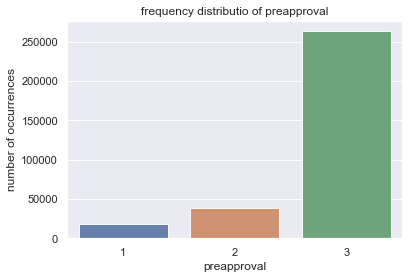

In [147]:
freq_dist(df_cat_train)

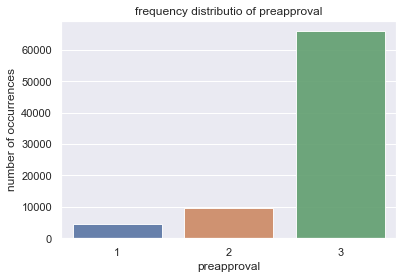

In [148]:
freq_dist(df_cat_test)

In [149]:
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_ethnicity  \
0          1              1          1            3                    2   
1          1              1          1            2                    2   
2          1              1          1            3                    1   
3          1              1          1            3                    2   
4          1              1          1            3                    1   

   applicant_race  applicant_sex  loan_purpose__1  loan_purpose__2  \
0               5              1                0                1   
1               5              1                1                0   
2               5              1                1                0   
3               5              1                0                0   
4               5              1                0                0   

   loan_purpose__3  
0                0  
1                0  
2                0  
3                1  
4                1

In [150]:
def freq_dist(df_categories):
    category_count = df_categories['applicant_ethnicity'].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_count.index,category_count.values, alpha = 0.9)
    plt.title('frequency distributio of applicant_ethnicity')
    plt.ylabel('number of occurrences',fontsize = 12)
    plt.xlabel('applicant_ethnicity',fontsize = 12)
    plt.show()

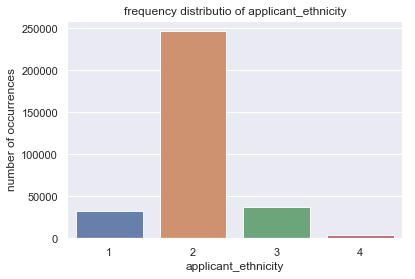

In [151]:
freq_dist(df_cat_train)

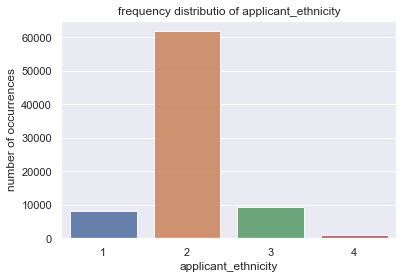

In [152]:
freq_dist(df_cat_test)

In [153]:
df_cat_train = pd.concat([df_cat_train,pd.get_dummies(df_cat_train['applicant_ethnicity'],prefix='applicant_ethnicity_',drop_first= False)],axis = 1)
df_cat_train.drop(columns=['applicant_ethnicity'],inplace= True,axis=1)
df_cat_test = pd.concat([df_cat_test,pd.get_dummies(df_cat_test['applicant_ethnicity'],prefix='applicant_ethnicity_',drop_first= False)],axis = 1)
df_cat_test.drop(columns=['applicant_ethnicity'],inplace= True,axis=1)
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_race  \
0          1              1          1            3               5   
1          1              1          1            2               5   
2          1              1          1            3               5   
3          1              1          1            3               5   
4          1              1          1            3               5   

   applicant_sex  loan_purpose__1  loan_purpose__2  loan_purpose__3  \
0              1                0                1                0   
1              1                1                0                0   
2              1                1                0                0   
3              1                0                0                1   
4              1                0                0                1   

   applicant_ethnicity__1  applicant_ethnicity__2  applicant_ethnicity__3  \
0                       0                       1                       0   
1                       0                       1                       0   
2                       1                       0                       0   
3                       0                       1                       0   
4                       1                       0                       0   

   applicant_ethnicity__4  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [154]:
cols = ['applicant_ethnicity__1','applicant_ethnicity__2','applicant_ethnicity__3','applicant_ethnicity__4']
col = 'applicant_ethnicity'

In [155]:
new_train , new_test = categorical_func(train_copy,test_copy,df_cat_train,df_cat_test,col,cols)
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_race  applicant_sex  \
0      77          31           20               5              1   
1     358          32            2               5              1   
2     139           3          299               5              1   
3     266          48           83               5              1   
4     171          52          257               5              1   

   applicant_income  population  minority_population_pct  \
0              14.0      1993.0                   29.525   
1             143.0      4402.0                   42.265   
2              48.0      7829.0                   44.841   
3             454.0      4691.0                    9.089   
4              25.0      2408.0                   30.840   

   ffiecmedian_family_income  tract_to_msa_md_income_pct  \
0                    58433.0                      68.959   
1                   109352.0                     100.000   
2                    98621.0                     100.000   
3                   112005.0                     100.000   
4                    75925.0                      92.052   

   number_of_owner-occupied_units  number_of_1_to_4_family_units  lender  \
0                           918.0                          942.0    5053   
1                           773.0                         1081.0    5952   
2                          1799.0                         1968.0    4576   
3                          1561.0                         1982.0    3108   
4                           670.0                          893.0    5113   

   co_applicant  accepted  applicant_income_NA  population_NA  \
0         False         0                    0              0   
1          True         1                    0              0   
2         False         1                    0              0   
3          True         0                    0              0   
4         False         1                    0              0   

   number_of_owner-occupied_units_NA  number_of_1_to_4_family_units_NA  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

   loan_purpose__1  loan_purpose__2  loan_purpose__3  applicant_ethnicity__1  \
0                0                1                0                       0   
1                1                0                0                       0   
2                1                0                0                       1   
3                0                0                1                       0   
4                0                0                1                       1   

   applicant_ethnicity__2  applicant_ethnicity__3  applicant_ethnicity__4  
0                       1                       0                       0  
1                       1                       0                       0  
2                       0                       0                       0  
3                       1                       0                       0  
4                       0                       0                       0

In [156]:
# X_train, X_test, y_train, y_test = train_test_split(new_train, new_train.accepted, test_size=0.33, random_state=42)

# #get cols names
# X_train_cols = list(X_train.columns)
# X_test_cols = list(X_test.columns)
# #standard scale 
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train))
# X_test = pd.DataFrame(scaler.transform(X_test))
# # rename the cols of the dataset again since scaler returns a numpy arrray
# X_train.columns=X_train_cols
# X_test.columns =X_test_cols

In [157]:
# # base model

# logit = LogisticRegression(random_state=42,C=1000)
# logit.fit(X_train.drop(['row_id','accepted'],axis=1),y_train)
# print('Train set mean imputation')
# pred = logit.predict_proba(X_train.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
# pred = logit.predict(X_train.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
# print('Test set mean imputation')
# pred = logit.predict_proba(X_test.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
# pred = logit.predict(X_test.drop(['row_id','accepted'],axis=1))
# print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
# print()


In [158]:
#updating testcopy since there is improvement
train_copy = new_train
test_copy = new_test

In [159]:
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_race  \
0          1              1          1            3               5   
1          1              1          1            2               5   
2          1              1          1            3               5   
3          1              1          1            3               5   
4          1              1          1            3               5   

   applicant_sex  loan_purpose__1  loan_purpose__2  loan_purpose__3  \
0              1                0                1                0   
1              1                1                0                0   
2              1                1                0                0   
3              1                0                0                1   
4              1                0                0                1   

   applicant_ethnicity__1  applicant_ethnicity__2  applicant_ethnicity__3  \
0                       0                       1                       0   
1                       0                       1                       0   
2                       1                       0                       0   
3                       0                       1                       0   
4                       1                       0                       0   

   applicant_ethnicity__4  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [160]:
def freq_dist(df_categories):
    category_count = df_categories['applicant_race'].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_count.index,category_count.values, alpha = 0.9)
    plt.title('frequency distributio of applicant_race')
    plt.ylabel('number of occurrences',fontsize = 12)
    plt.xlabel('applicant_race',fontsize = 12)
    plt.show()

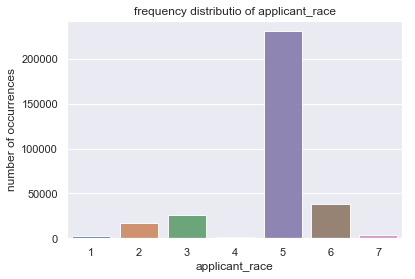

In [161]:
freq_dist(df_cat_train)

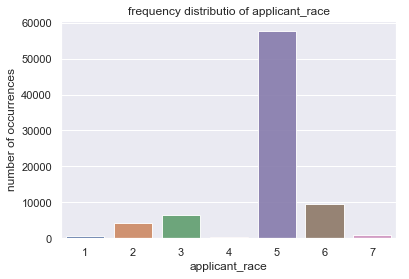

In [162]:
freq_dist(df_cat_test)

In [163]:
df_cat_train = pd.concat([df_cat_train,pd.get_dummies(df_cat_train['applicant_race'],prefix='applicant_race_',drop_first= False)],axis = 1)
df_cat_train.drop(columns=['applicant_race'],inplace= True,axis=1)
df_cat_test = pd.concat([df_cat_test,pd.get_dummies(df_cat_test['applicant_race'],prefix='applicant_race_',drop_first= False)],axis = 1)
df_cat_test.drop(columns=['applicant_race'],inplace= True,axis=1)
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_sex  \
0          1              1          1            3              1   
1          1              1          1            2              1   
2          1              1          1            3              1   
3          1              1          1            3              1   
4          1              1          1            3              1   

   loan_purpose__1  loan_purpose__2  loan_purpose__3  applicant_ethnicity__1  \
0                0                1                0                       0   
1                1                0                0                       0   
2                1                0                0                       1   
3                0                0                1                       0   
4                0                0                1                       1   

   applicant_ethnicity__2  applicant_ethnicity__3  applicant_ethnicity__4  \
0                       1                       0                       0   
1                       1                       0                       0   
2                       0                       0                       0   
3                       1                       0                       0   
4                       0                       0                       0   

   applicant_race__1  applicant_race__2  applicant_race__3  applicant_race__4  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   applicant_race__5  applicant_race__6  applicant_race__7  
0                  1                  0                  0  
1                  1                  0                  0  
2                  1                  0                  0  
3                  1                  0                  0  
4                  1                  0                  0

In [164]:
cols = ['applicant_race__1','applicant_race__2','applicant_race__3','applicant_race__4','applicant_race__5','applicant_race__6','applicant_race__7']
col = 'applicant_race'

In [165]:
new_train , new_test = categorical_func(train_copy,test_copy,df_cat_train,df_cat_test,col,cols)
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  applicant_race__1  \
0                       0                       0                  0   
1                       0                       0                  0   
2                       0                       0                  0   
3                       0                       0                  0   
4                       0                       0                  0   

   applicant_race__2  applicant_race__3  applicant_race__4  applicant_race__5  \
0                  0                  0                  0               

In [166]:
# X_train, X_test, y_train, y_test = train_test_split(new_train, new_train.accepted, test_size=0.33, random_state=42)

# #get cols names
# X_train_cols = list(X_train.columns)
# X_test_cols = list(X_test.columns)
# #standard scale 
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train))
# X_test = pd.DataFrame(scaler.transform(X_test))
# # rename the cols of the dataset again since scaler returns a numpy arrray
# X_train.columns=X_train_cols
# X_test.columns =X_test_cols

In [167]:
# base model

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['row_id','accepted'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


Train set mean imputation
Logistic Reg roc-auc: 0.707156862293692
Logistic Reg accuracy: 0.6515438432835821
Test set mean imputation
Logistic Reg roc_auc: 0.7056283807131638
Logistic Reg accuracy: 0.6508522727272728



In [168]:
#drop dummies for the above feature
new_train.drop(columns=cols,inplace=True)
new_test.drop(columns=cols,inplace=True)
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  
0                       0                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0

In [169]:
df_cat_train.head()

loan_type  property_type  occupancy  preapproval  applicant_sex  \
0          1              1          1            3              1   
1          1              1          1            2              1   
2          1              1          1            3              1   
3          1              1          1            3              1   
4          1              1          1            3              1   

   loan_purpose__1  loan_purpose__2  loan_purpose__3  applicant_ethnicity__1  \
0                0                1                0                       0   
1                1                0                0                       0   
2                1                0                0                       1   
3                0                0                1                       0   
4                0                0                1                       1   

   applicant_ethnicity__2  applicant_ethnicity__3  applicant_ethnicity__4  \
0                       1                       0                       0   
1                       1                       0                       0   
2                       0                       0                       0   
3                       1                       0                       0   
4                       0                       0                       0   

   applicant_race__1  applicant_race__2  applicant_race__3  applicant_race__4  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   applicant_race__5  applicant_race__6  applicant_race__7  
0                  1                  0                  0  
1                  1                  0                  0  
2                  1                  0                  0  
3                  1                  0                  0  
4                  1                  0                  0

In [170]:
np.shape(new_train),np.shape(new_test)

((320000, 31), (80000, 30))

In [171]:
#updating testcopy since there is improvement
train_copy = new_train
test_copy = new_test

In [172]:
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  
0                       0                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0

In [173]:
train_copy.shape,test_copy.shape

((320000, 31), (80000, 30))

## dont touch the next cell if not necessary

In [174]:
#reserving copied version of train and set up to this stage 
train_copy1 = train_copy.copy()
test_copy1 = test_copy.copy()
train_copy1.to_csv('train_copy1.csv',index = False)
test_copy1.to_csv('test_copy1.csv',index = False)

## Analysis

In [175]:
train_copy1 = pd.read_csv("train_copy1.csv")
test_copy1 = pd.read_csv("test_copy1.csv")

In [176]:
np.shape(train_copy1),np.shape(test_copy1)

((320000, 31), (80000, 30))

In [177]:
new_train = train_copy1
new_test = test_copy1

In [178]:
new_train.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  
0                       0                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0

In [179]:
new_test.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  304897          2              1          1        113.0            3   
1  386541          1              1          1         10.0            3   
2  453817          1              1          1        270.0            3   
3  352553          3              1          1        514.0            3   
4  273259          1              1          1         92.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0     356           5           98              1              47.0   
1      10          34           11              1              12.0   
2      24          37           20              2              75.0   
3      10          34           11              1             159.0   
4     150          14            3              1              43.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      3256.0                   24.824                    52771.0   
1      7274.0                   16.243                    87259.0   
2      4835.0                   86.704                    64204.0   
3      7542.0                   15.455                    87564.0   
4      5407.0                   18.518                    63502.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                     100.000                           800.0   
1                     100.000                          2097.0   
2                     100.000                           864.0   
3                      97.056                          2529.0   
4                     100.000                          1747.0   

   number_of_1_to_4_family_units  lender  co_applicant  applicant_income_NA  \
0                         1013.0    5684         False                    0   
1                         2674.0    4701          True                    0   
2                         1049.0    5123          True                    0   
3                         2985.0     814         False                    0   
4                         1888.0    1143         False                    0   

   population_NA  number_of_owner-occupied_units_NA  \
0              0                                  0   
1              0                                  0   
2              0                                  0   
3              0                                  0   
4              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                0   
1                                 0                0                1   
2                                 0                0                0   
3                                 0                1                0   
4                                 0                1                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                1                       0                       0   
1                0                       0                       1   
2                1                       1                       0   
3                0                       0                       1   
4                0                       0                       1   

   applicant_ethnicity__3  applicant_ethnicity__4  
0                       1                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0

## feature engineering with additional features

## 1.0 Loan acceptance rates across ethnicity and gender

In [180]:
training = new_train.copy()
testing = new_test.copy()

In [181]:
## 1.1.2 applicant income loan ratio 
training['income_loan_ratio'] = training.loan_amount / (training.applicant_income + 1) 
testing['income_loan_ratio'] = testing.loan_amount / (testing.applicant_income + 1) 
training['income_loan_ratio'].tail()

319995    5.370370
319996    2.107843
319997    3.642857
319998    2.446429
319999    2.577922
Name: income_loan_ratio, dtype: float64

In [182]:
X_train, X_test, y_train, y_test = train_test_split(training, training.accepted, test_size=0.33, random_state=42)

#get cols names
X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)
#standard scale 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
# rename the cols of the dataset again since scaler returns a numpy arrray
X_train.columns=X_train_cols
X_test.columns =X_test_cols

In [183]:
# base model

logit = LogisticRegression(random_state=42,C=1000)
logit.fit(X_train.drop(['row_id','accepted'],axis=1),y_train)
print('Train set mean imputation')
pred = logit.predict_proba(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = logit.predict(X_train.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set mean imputation')
pred = logit.predict_proba(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg roc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = logit.predict(X_test.drop(['row_id','accepted'],axis=1))
print('Logistic Reg accuracy: {}'.format(accuracy_score(y_test,pred)))
print()

Train set mean imputation
Logistic Reg roc-auc: 0.7187005890907004
Logistic Reg accuracy: 0.6600932835820895
Test set mean imputation
Logistic Reg roc_auc: 0.7169224615647083
Logistic Reg accuracy: 0.6592613636363637



In [184]:
training.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053         False         0   
1                         1081.0    5952          True         1   
2                         1968.0    4576         False         1   
3                         1982.0    3108          True         0   
4                          893.0    5113         False         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  income_loan_ratio  
0                       0                       0           5.200000  
1                       0                       0           2.236111  
2                       0                       0           2.938776  
3                       0                       0           1.149451  
4                       0                       0           5.500000

In [185]:
enc = LabelEncoder()

In [186]:
training.co_applicant = enc.fit_transform(training.co_applicant)
testing.co_applicant = enc.transform(testing.co_applicant)

In [187]:
training.head()

row_id  loan_type  property_type  occupancy  loan_amount  preapproval  \
0  110049          1              1          1         78.0            3   
1   83668          1              1          1        322.0            2   
2  253898          1              1          1        144.0            3   
3   97905          1              1          1        523.0            3   
4  417495          1              1          1        143.0            3   

   msa_md  state_code  county_code  applicant_sex  applicant_income  \
0      77          31           20              1              14.0   
1     358          32            2              1             143.0   
2     139           3          299              1              48.0   
3     266          48           83              1             454.0   
4     171          52          257              1              25.0   

   population  minority_population_pct  ffiecmedian_family_income  \
0      1993.0                   29.525                    58433.0   
1      4402.0                   42.265                   109352.0   
2      7829.0                   44.841                    98621.0   
3      4691.0                    9.089                   112005.0   
4      2408.0                   30.840                    75925.0   

   tract_to_msa_md_income_pct  number_of_owner-occupied_units  \
0                      68.959                           918.0   
1                     100.000                           773.0   
2                     100.000                          1799.0   
3                     100.000                          1561.0   
4                      92.052                           670.0   

   number_of_1_to_4_family_units  lender  co_applicant  accepted  \
0                          942.0    5053             0         0   
1                         1081.0    5952             1         1   
2                         1968.0    4576             0         1   
3                         1982.0    3108             1         0   
4                          893.0    5113             0         1   

   applicant_income_NA  population_NA  number_of_owner-occupied_units_NA  \
0                    0              0                                  0   
1                    0              0                                  0   
2                    0              0                                  0   
3                    0              0                                  0   
4                    0              0                                  0   

   number_of_1_to_4_family_units_NA  loan_purpose__1  loan_purpose__2  \
0                                 0                0                1   
1                                 0                1                0   
2                                 0                1                0   
3                                 0                0                0   
4                                 0                0                0   

   loan_purpose__3  applicant_ethnicity__1  applicant_ethnicity__2  \
0                0                       0                       1   
1                0                       0                       1   
2                0                       1                       0   
3                1                       0                       1   
4                1                       1                       0   

   applicant_ethnicity__3  applicant_ethnicity__4  income_loan_ratio  
0                       0                       0           5.200000  
1                       0                       0           2.236111  
2                       0                       0           2.938776  
3                       0                       0           1.149451  
4                       0                       0           5.500000

In [188]:
training.columns

Index(['row_id', 'loan_type', 'property_type', 'occupancy', 'loan_amount',
       'preapproval', 'msa_md', 'state_code', 'county_code', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant', 'accepted', 'applicant_income_NA',
       'population_NA', 'number_of_owner-occupied_units_NA',
       'number_of_1_to_4_family_units_NA', 'loan_purpose__1',
       'loan_purpose__2', 'loan_purpose__3', 'applicant_ethnicity__1',
       'applicant_ethnicity__2', 'applicant_ethnicity__3',
       'applicant_ethnicity__4', 'income_loan_ratio'],
      dtype='object')

In [189]:
training.to_csv('training.csv',index = False)
testing.to_csv('testing.csv',index = False)

In [231]:
training = pd.read_csv('training.csv')
testing = pd.read_csv('testing.csv')

In [232]:
# training.drop(columns=['applicant_race'],axis=1,inplace=True)
# testing.drop(columns=['applicant_race'],axis=1,inplace=True)

In [233]:
X = training.drop(columns=['row_id','accepted'],axis = 1)
test = testing.drop(columns=['row_id'])
y = training.accepted

In [234]:
np.shape(X),np.shape(y),np.shape(test)

((320000, 30), (320000,), (80000, 30))

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Models

In [243]:
seed = 42

# Gradient Boosting Classifier

In [248]:
gradientboost = GradientBoostingClassifier(n_estimators= 300,learning_rate=0.1,random_state=42)

In [249]:
gradientboost.fit(X_train,y_train)
print('Train set imputation')
pred = gradientboost.predict_proba(X_train)
print('gradientboost roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
pred = gradientboost.predict(X_train)
print('gradientboost accuracy: {}'.format(accuracy_score(y_train,pred)))
print('Test set')
pred = gradientboost.predict_proba(X_test)
print('gradientboostroc_auc: {}'.format(roc_auc_score(y_test,pred[:,1])))
pred = gradientboost.predict(X_test)
print('gradientboost accuracy: {}'.format(accuracy_score(y_test,pred)))
print()


Train set mean imputation
gradientboost roc-auc: 0.7780017110452583
gradientboost accuracy: 0.7078917910447761
Test set mean imputation
gradientboostroc_auc: 0.7729203862664716
gradientboost accuracy: 0.7030776515151516



In [250]:
gradientboost.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [251]:
save_file_name = 'classification.pkl'
joblib.dump(gradientboost, save_file_name)
print('saved pipeline')

saved pipeline


In [252]:
classifier = joblib.load('classification.pkl')

In [253]:
pred = classifier.predict(test)

In [254]:
pred[0]

0

In [255]:
list(pred).count(1)

45931

In [256]:
list(pred).count(0)

34069